## Time Series Models from the ARIMA Family

In [1]:
# load necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.model_selection import train_test_split


In [2]:
## import and prepare montly data

monthly_data = pd.read_csv("../Data/monthly_data.csv")
# convert DateTime column into datetime format
monthly_data["datetime"] = pd.to_datetime(monthly_data['datetime'])
# set DateTime as index
monthly_data.set_index("datetime", inplace=True)
water_monthly = monthly_data[["water_level"]]

## import and prepare weekly data

weekly_data = pd.read_csv("../Data/weekly_data.csv")
# convert DateTime column into datetime format
weekly_data["datetime"] = pd.to_datetime(weekly_data['datetime'])
# set DateTime as index
weekly_data.set_index("datetime", inplace=True)
water_weekly = weekly_data[["water_level"]]

In [7]:
water_weekly

,water_level
datetime,
2012-01-01 00:00:00+01:00,405.911957
2012-01-08 00:00:00+01:00,405.926036
2012-01-15 00:00:00+01:00,405.856681
2012-01-22 00:00:00+01:00,405.811482
2012-01-29 00:00:00+01:00,405.828595
...,...
2019-11-03 00:00:00+01:00,405.981773
2019-11-10 00:00:00+01:00,406.005953
2019-11-17 00:00:00+01:00,405.973563


In [3]:
# function for calculating different performance measures

from sklearn.metrics import mean_absolute_error as mae
import numpy as np
from sklearn.metrics import r2_score

def mean_errors(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAE = mae(actual, pred)
    MSE = np.square(np.subtract(actual,pred)).mean()
    MAPE = np.mean(np.abs((actual - pred) / actual)) * 100
    R2_score = r2_score(actual, pred)
    return print("MAE: {} \nMSE: {} \nMAPE: {} \nR2: {}".format(MAE, MSE, MAPE, R2_score))

# Monthly Data

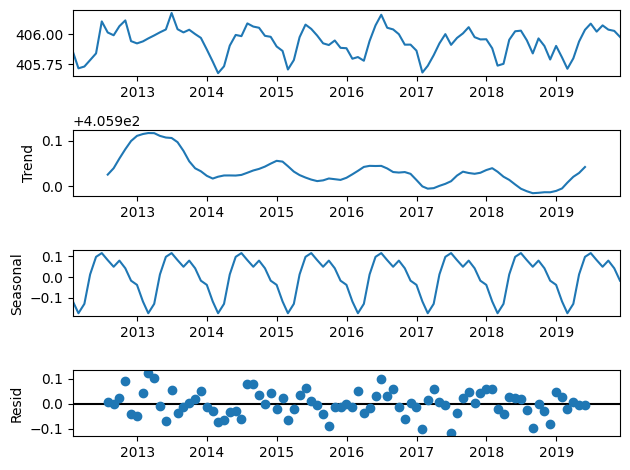

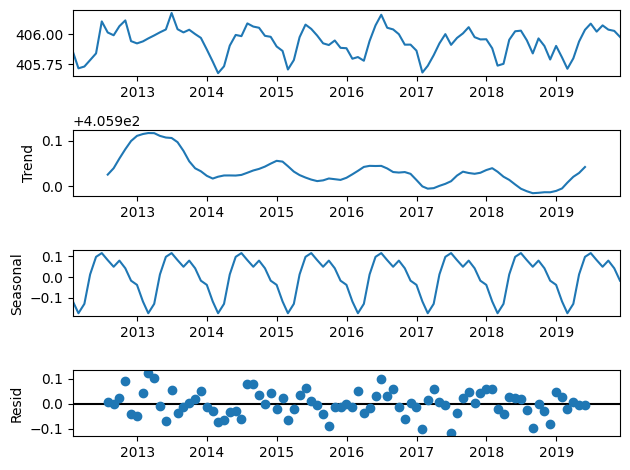

In [58]:
# decompose the monthly data to find out trends and and seasonalites 
seasonal_decompose(water_monthly).plot()

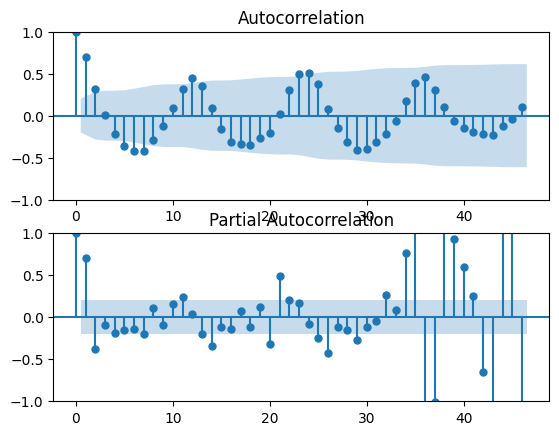

In [76]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(water_monthly, lags=46, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(water_monthly, lags=46, ax=ax[1])
plt.show()

# the first two lags of the partial autocorrelation are still significant which suggests that the time series is non stationary 

In [77]:
# check for stationarity with the ADF test
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(water_monthly)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

# the p value is above 0.05, so the null hypthesis gets rejected and the water level time series is non stationary 

ADF test statistic: -2.229628828447892
ADF p-values: 0.1956681472226814
ADF number of lags used: 10
ADF number of observations: 84
ADF critical values: {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
ADF best information criterion: -195.11819099343586


<AxesSubplot: xlabel='datetime'>

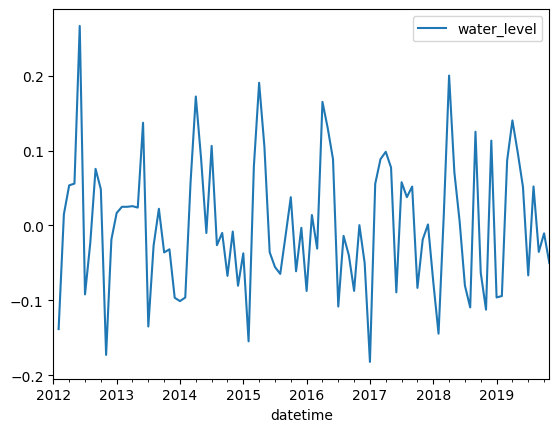

In [78]:
# differencing water level data to make it stationary 
prev_monthly_value = water_monthly.shift()
differenced_monthly = water_monthly - prev_monthly_value
differenced_monthly.plot()

In [79]:
# ADF test on differenced data, the p value is now below 0.05 and suggests that the time series is now stationary after differencing once
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced_monthly.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -3.1463403734040645
ADF p-values: 0.023308502613789233
ADF number of lags used: 12
ADF number of observations: 81
ADF critical values: {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
ADF best information criterion: -189.12927178184964


# Auto Arima Model Monthly

In [82]:
# split the differenced, stationary monthly data into training and test datasets, the data from 2018 onwards is selected as testdata 
train_diff, test_diff = train_test_split(differenced_monthly, train_size=72)

 ARIMA(1,0,1)(2,0,0)[12] intercept


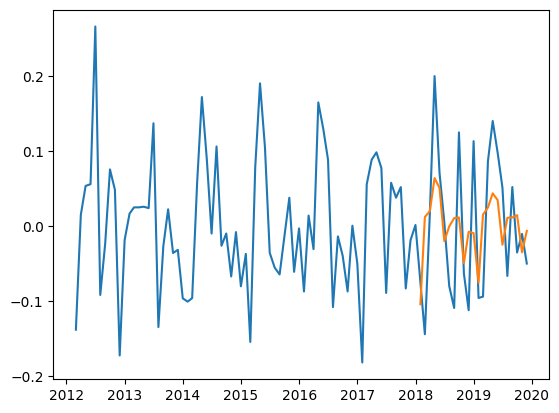

MAE: 0.06917243678107295 
MSE: 0.010318622815440739 
MAPE: 134.59946705972047 
R2: 0.2498827794970725
None


In [120]:
# instantiate and fit the autoarima model with the differenced trainings data 

# we are using the differenced data because the auto arima model doesn´t differentiates the data to make it stationary (d=0) and in this case 
# the predictions for the unseen training data are quite linear and do not really match the fluctuations of the water level. 
# by using the differenced data we circumvent this problem but get instead the change rate on the plot and not the absolut water level data

# seasonal is set to true since we have seasonality and m is the periocidy of the data since it is monthly data
auto_arima_model = pm.auto_arima(train_diff.dropna(), seasonal=True, m=12)
preds = auto_arima_model.predict(test_diff.shape[0])
# predict the test data with the auto-ARIMA-model
preds_auto_arima = auto_arima_model.predict(test_diff.shape[0])
# display the parameters the auto_arima function selected 
print(auto_arima_model)

# plot the actual and predicted change rate of the water level
plt.plot(differenced_monthly.index, differenced_monthly)
plt.plot(differenced_monthly.index[72:], preds_auto_arima)
plt.show()

# print different errors to evaluate performance
print(mean_errors(test_diff, preds_auto_arima))

# Sarima Model Monthly

In [121]:
# train test split for SARIMA model
train, test = train_test_split(water_monthly, train_size=72)

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978

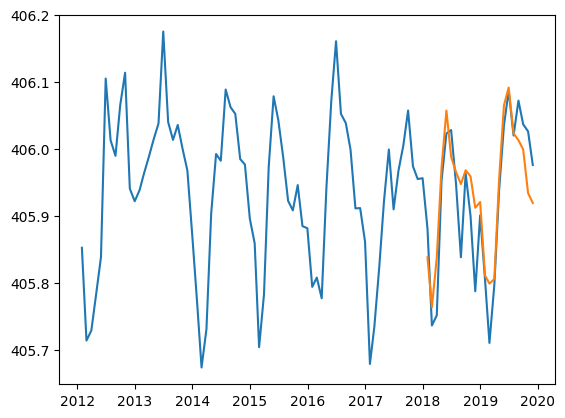

MAE: 0.04293758304676055 
MSE: 0.020626518063662124 
MAPE: 0.028655661060702272 
R2: 0.7560156074017839
None


In [139]:
# instantiate and fit arima model manually with seasonal parameters
# we chose d and D = 1 because the series is non stationary
# we chose p adn P = 2 because the first lags in the ACF and PACF plots have significant spikes, q dn Q = 1 because there were also 
# negative autocorrelations. The ultimate combination of the seven parameters was choosen by varying some of the parameters until we found the
# model with the lowest mean errors and the highest R2 
arima_manual = ARIMA(train, order=(2,1,1), seasonal_order=(2,1,1,12))
arima_manual_fit = arima_manual.fit()
# predict future values using the model
preds_arima_manual = arima_manual_fit.forecast(len(test))

# plotting actual and predicted water level
plt.plot(water_monthly.index, water_monthly)
plt.plot(water_monthly.index[72:], preds_arima_manual)
plt.show()

# print performance indicators
print(mean_errors(test, preds_arima_manual))

# SARIMAX Model Monthly 

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -0.974854
         Iterations: 9
         Function evaluations: 961


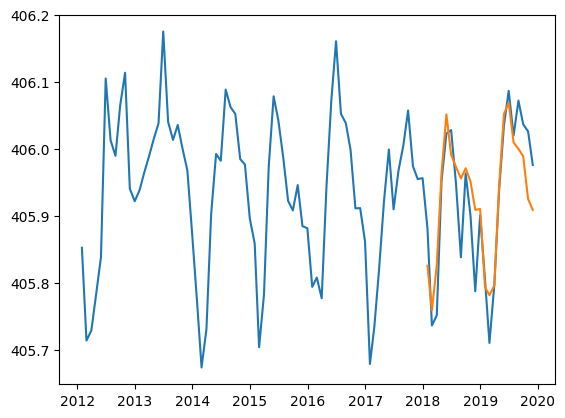

MAE: 0.04273655169943733 
MSE: 0.020578971311537676 
MAPE: 0.028646090505593035 
R2: 0.7526434684796052
None


In [140]:
# model with Sarimax
import statsmodels.api as sm
model_max = sm.tsa.statespace.SARIMAX(train, order=(2,1,2), seasonal_order=(2,1,1,12)).fit(max_iter=50, method='powell')
# predicting with model
preds_max = model_max.forecast(len(test))
# plotting prediction and actual values
plt.plot(water_monthly.index, water_monthly)
plt.plot(water_monthly.index[72:], preds_max)
plt.show()

print(mean_errors(test,preds_max))

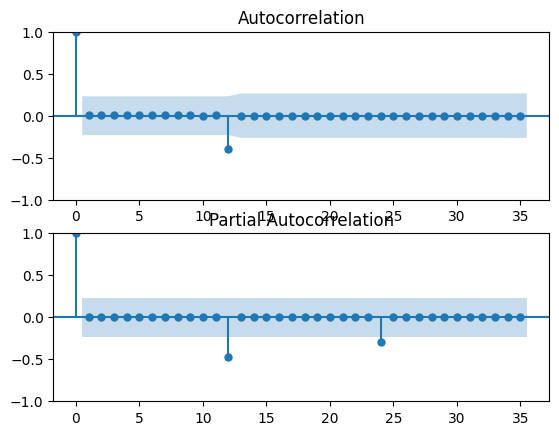

In [19]:
# plot ACF and PACF curve for residuals of SARIMAX model

res = model_max.resid

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=35, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=35, ax=ax[1])
plt.show()

In [4]:
# data = entire dataset
# n_test = point where data is split into training and test sets
def walk_forward_validation(data, n_test):
    predictions = np.array([])
    mape_list = []
    train, test = data[:n_test], data[n_test:]
    day_list = [6,12,18,24] # weeks 1,2,3,4    
    for i in day_list:
        # Fit model to training data
        model = sm.tsa.statespace.SARIMAX(train, order=(2,1,2), seasonal_order=(2,1,1,12)).fit(max_iter = 50, method = 'powell')
                
        # Forecast daily loads for week i
        forecast = model.get_forecast(steps = 6)
        predictions = np.concatenate(predictions, forecast, axis=None)        # Calculate MAPE and add to mape_list
        j = i-6
        mape_score = (abs(test[j:i] - predictions[j:i])/test[j:i])*100
        mape_mean = mape_score.mean()
        mape_list.append(mape_mean)        # Add week i to training data for next loop
        train = np.concatenate((train, test[j:i]), axis=None)
    return predictions, mape_list

In [5]:
walk_forward_validation(water,72)

NameError: name 'water' is not defined

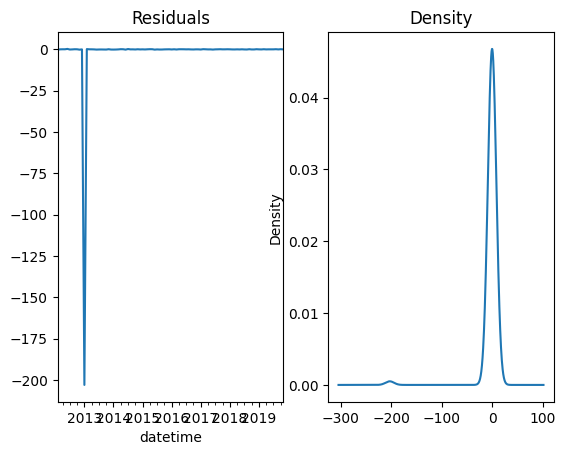

In [140]:
residuals = model_manual_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()


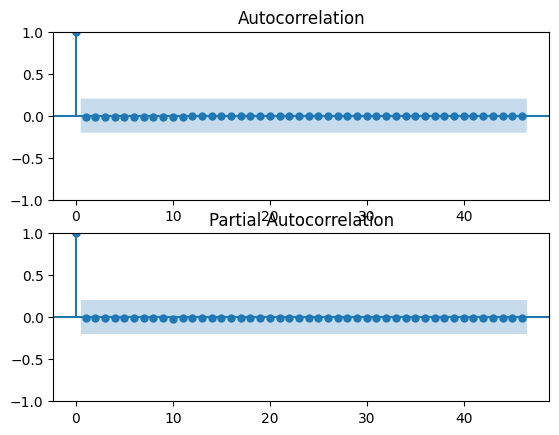

In [143]:
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(residuals, lags=46, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=46, ax=ax[1])
plt.show()

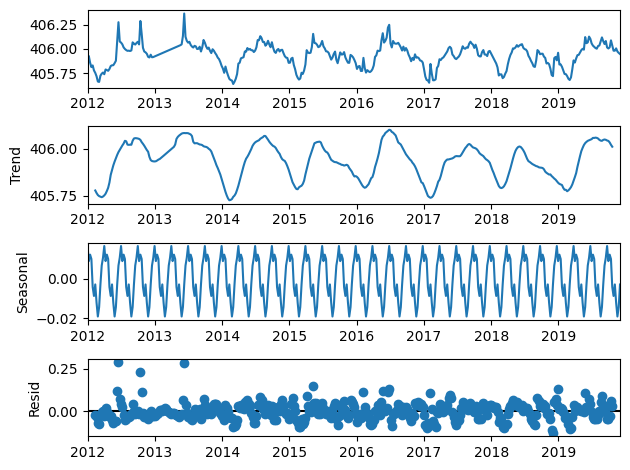

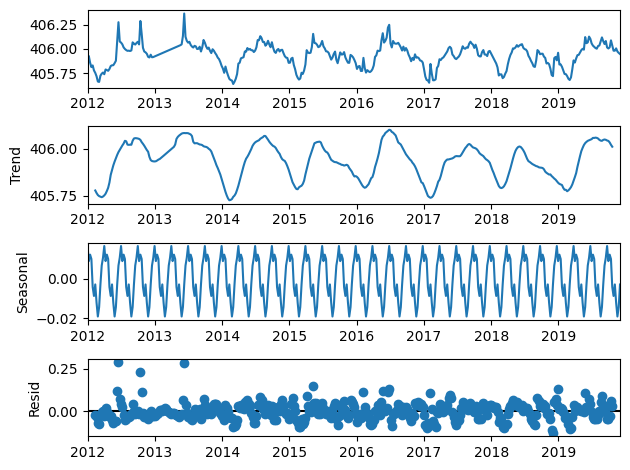

In [141]:
# decompose the monthly data to find out trends and and seasonalites 
seasonal_decompose(water_weekly,  period=13).plot()

# setting period to 13 to find quarterly seasonalities

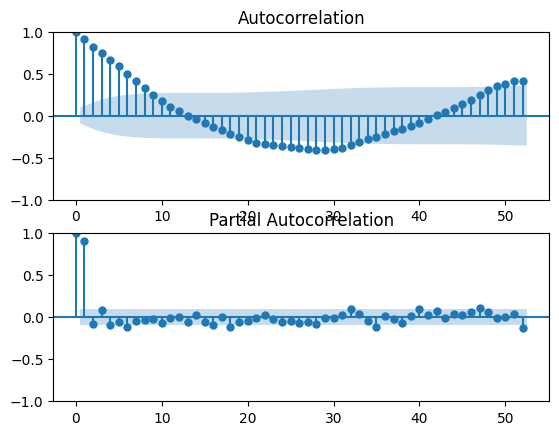

In [144]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(water_weekly, lags=52, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(water_weekly, lags=52, ax=ax[1])
plt.show()


In [145]:
# check for stationarity with the ADF test
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(water_weekly)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -4.982589900225232
ADF p-values: 2.4022962615431937e-05
ADF number of lags used: 5
ADF number of observations: 408
ADF critical values: {'1%': -3.446479704252724, '5%': -2.8686500930967354, '10%': -2.5705574627547096}
ADF best information criterion: -1243.505402180334


In [12]:
train_we, test_we = train_test_split(water_weekly, train_size=366)

In [183]:
train_all, test_all = train_test_split(weekly_data, train_size=314)

In [ ]:
# instantiate and fit the autoarima model with the weekly trainings data 

# seasonal is set to true since we have seasonality and m is the periocidy of the data since it is weekly data
auto_arima_we = pm.auto_arima(train_we.dropna(), seasonal=True, m=52)
preds = auto_arima_we.predict(test_we.shape[0])
# predict the test data with the auto-ARIMA-model
preds_auto_we = auto_arima_we.predict(test_we.shape[0])
# display the parameters the auto_arima function selected 
print(auto_arima_we)

# plot the actual and predicted change rate of the water level
plt.plot(water_weekly.index, water_weekly)
plt.plot(water_weekly.index[314:], preds_auto_we)
plt.show()

# print different errors to evaluate performance
print(mean_errors(test_we, preds_auto_we))

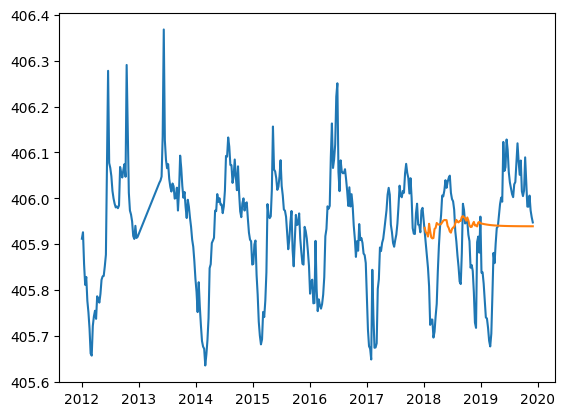

MAE: 0.09674969830158034 
MSE: 0.014064142062946346 
MAPE: 0.02398221349722815 
R2: -0.008001338711256079
None


In [158]:

# plot the actual and predicted change rate of the water level
plt.plot(water_weekly.index, water_weekly)
plt.plot(water_weekly.index[314:], preds_auto_we)
plt.show()

# print different errors to evaluate performance
print(mean_errors(test_we, preds_auto_we))

# Seasonal ARIMA Model Weekly

In [17]:
# split training data into training and testing set for validation
train_val, test_val = train_test_split(train_we, train_size=314)

In [21]:
arima_manual_we = ARIMA(train_val, order=(2,0,0), seasonal_order=(1,1,2,52))
arima_we_fit = arima_manual_we.fit()
# predict future values using the model
preds_arima_we = arima_we_fit.forecast(len(test_val))


c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-package

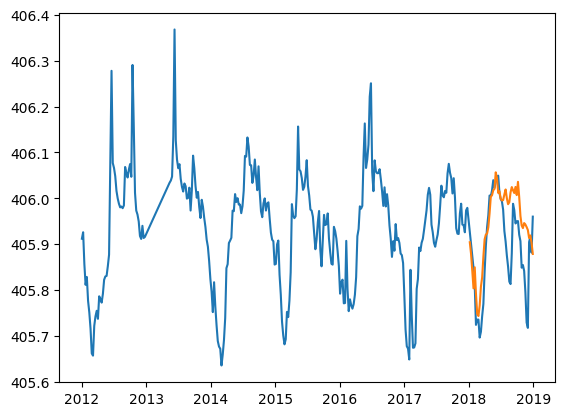

MAE: 0.06265348213917193 
MSE: 0.0189987232566919 
MAPE: 0.027197461139701864 
R2: 0.28430682789665207
None


In [26]:

# plotting actual and predicted water level
plt.plot(train_we.index, train_we)
plt.plot(train_we.index[314:], preds_arima_we)
plt.show()

# print performance indicators
print(mean_errors(test_val, preds_arima_we))

In [27]:
forecast_arima_we = arima_we_fit.forecast(len(test_we))


c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


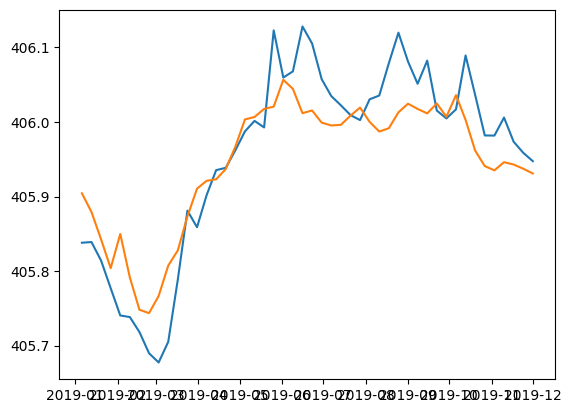

MAE: 0.043773334726672886 
MSE: 0.022880384407845705 
MAPE: 0.029413829868540072 
R2: 0.8103779835442417
None


In [30]:

# plotting actual and predicted water level
plt.plot(test_we.index, test_we)
plt.plot(test_we.index, forecast_arima_we)
plt.show()

# print performance indicators
print(mean_errors(test_we, forecast_arima_we))

# SARIMA MODEL Weekly

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -1.188735
         Iterations: 10
         Function evaluations: 938


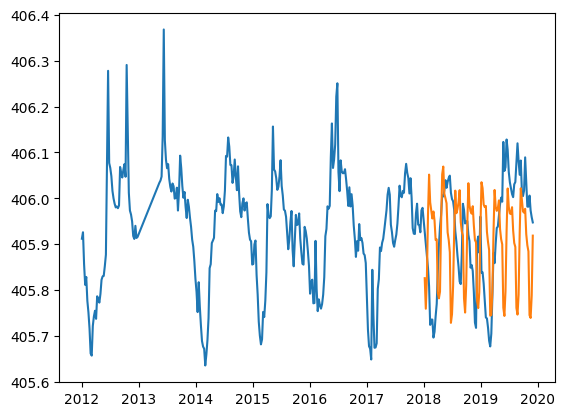

MAE: 0.13231115551780648 
MSE: 0.022339168692540358 
MAPE: 0.02973220238990858 
R2: -0.8080567904468914
None


In [186]:
# model with Sarimax
import statsmodels.api as sm
model_max_we = sm.tsa.statespace.SARIMAX(endog=train_we, exog=train_all["precipitation (mm)"], 
order=(2,0,0), seasonal_order=(2,1,1,52)).fit(max_iter=50, method='powell')
# predicting with model
preds_max_we = model_max.forecast(len(test_we))
# plotting prediction and actual values
plt.plot(water_weekly.index, water_weekly)
plt.plot(water_weekly.index[314:], preds_max_we)
plt.show()

print(mean_errors(test_we,preds_max_we))

In [182]:
weekly_data["outflow_limmat (m3/s)"]#.plot()

datetime
2012-01-01 00:00:00+01:00    141.302696
2012-01-08 00:00:00+01:00    130.655173
2012-01-15 00:00:00+01:00     98.241024
2012-01-22 00:00:00+01:00     85.367494
2012-01-29 00:00:00+01:00    101.413720
                                ...    
2019-11-03 00:00:00+01:00     85.093263
2019-11-10 00:00:00+01:00     99.203155
2019-11-17 00:00:00+01:00     92.942345
2019-11-24 00:00:00+01:00     78.785926
2019-12-01 00:00:00+01:00     67.687139
Name: outflow_limmat (m3/s), Length: 414, dtype: float64

<AxesSubplot: xlabel='datetime'>

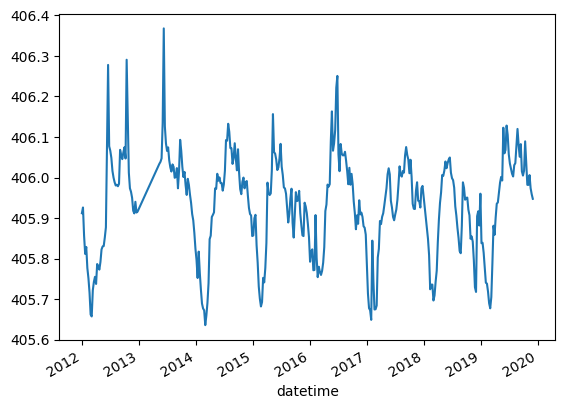

In [180]:
weekly_data["water_level"].plot()

In [187]:
from scipy.fft import fft, ifft

In [188]:
N = len(water_weekly)
yf = fft(water_weekly)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))
plt.show()

array([[405.91195652-0.j],
       [405.92603571-0.j],
       [405.85668056-0.j],
       [405.81148214-0.j],
       [405.82859524-0.j],
       [405.77660714-0.j],
       [405.75137923-0.j],
       [405.71587897-0.j],
       [405.6619246 -0.j],
       [405.65717659-0.j],
       [405.72193254-0.j],
       [405.74276984-0.j],
       [405.75496278-0.j],
       [405.73741071-0.j],
       [405.78653571-0.j],
       [405.78061508-0.j],
       [405.77269841-0.j],
       [405.79172619-0.j],
       [405.8225    -0.j],
       [405.82987103-0.j],
       [405.83092262-0.j],
       [405.8521131 -0.j],
       [405.8771627 -0.j],
       [406.08579365-0.j],
       [406.2778373 -0.j],
       [406.07698413-0.j],
       [406.06619078-0.j],
       [406.0482964 -0.j],
       [406.01616071-0.j],
       [405.99966667-0.j],
       [405.98809524-0.j],
       [405.9802381 -0.j],
       [405.98217262-0.j],
       [405.97849702-0.j],
       [405.98445238-0.j],
       [406.06827381-0.j],
       [406.05543651-0.j],
 

In [ ]:
# Korstanje, J. 2022.  How to Select a Model For Your Time Series Prediction Task. Retrieved from: 
# https://neptune.ai/blog/select-model-for-time-series-prediction-task 

# Graves, A. 2020. Time Series Forecasting with a SARIMA Model. Retrieved from: 
# https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459

#